In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [15]:
# IMPORTS
import itertools
import math
import random
import pickle
import os
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import matplotlib as mpl
import contextily as ctx
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from datetime import date
from shapely.geometry import Point, LineString
from sklearn.preprocessing import quantile_transform
from matplotlib.patches import Patch
from scipy.stats import ks_2samp, combine_pvalues

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from joblib import Parallel, delayed

In [6]:
# Original code from Lei et al. with minor fix for error
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return (7 * ratio * scale * nx, 7 * scale * ny)

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                   "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
                'font.family': 'sans-serif',
                'font.sans-serif': ['Helvetica'],
                'text.latex.preamble': r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{mathptmx}",
                'axes.labelsize': 30,
                'axes.titlesize': 30,
                'ytick.right': 'on',
                'xtick.top': 'on',
                'xtick.labelsize': '25',
                'ytick.labelsize': '25',
                'axes.linewidth': 1.8,
                'xtick.major.width': 1.8,
                'xtick.minor.width': 1.8,
                'xtick.major.size': 14,
                'xtick.minor.size': 7,
                'xtick.major.pad': 10,
                'xtick.minor.pad': 10,
                'ytick.major.width': 1.8,
                'ytick.minor.width': 1.8,
                'ytick.major.size': 14,
                'ytick.minor.size': 7,
                'ytick.major.pad': 10,
                'ytick.minor.pad': 10,
                'axes.labelpad': 15,
                'axes.titlepad': 15,
                "xtick.direction": "in",
                "ytick.direction": "in",
                'legend.fontsize': 20}
    mpl.rcParams.update(rcparams)

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

# Set rcparams
stdrcparams(usetex=False)  # Set usetex to False if LaTeX is not available

# Get standard figure size
figsize = stdfigsize(ratio=-1)
xs, ys = figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x', length=10, direction='out')
    ax.tick_params(axis='x', which='minor', direction='out')
    ax.tick_params(axis='y', length=10, direction='out')
    ax.tick_params(axis='y', which='minor', direction='out')

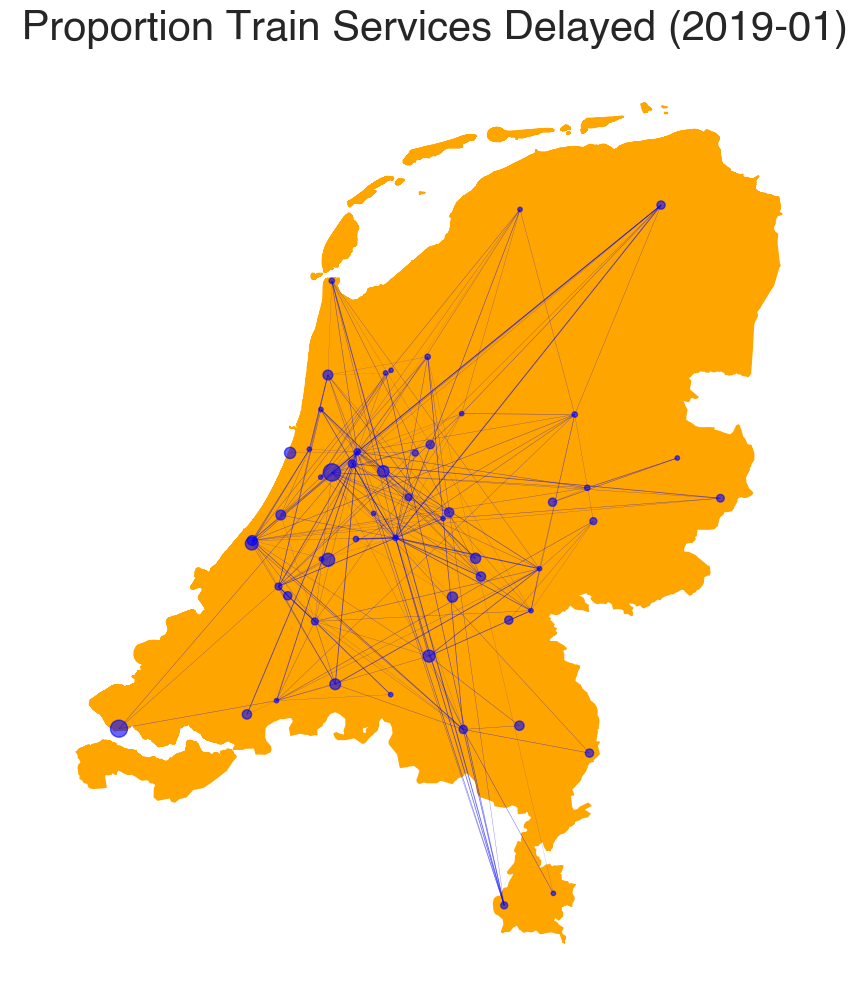

In [7]:
# VISUALIZE GRAPH ON MAP
# Function to visualize the graph on a custom map of the Netherlands
def visualize_graph_on_custom_map(graph, station_coords, shapefile_path, title="Graph on Map"):
    # Load the shapefile
    gdf_netherlands = gpd.read_file(shapefile_path)
    
    # Filter out unused stations
    used_stations = set(graph.nodes())
    filtered_coords = {station: coords for station, coords in station_coords.items() if station in used_stations}
    
    # Create a GeoDataFrame for stations
    gdf_nodes = gpd.GeoDataFrame(
        {'Station': list(filtered_coords.keys())},
        geometry=[Point(filtered_coords[station]['geo_lng'], filtered_coords[station]['geo_lat']) for station in filtered_coords],
        crs="EPSG:4326"
    )

    # Convert to the same CRS as the shapefile
    gdf_nodes = gdf_nodes.to_crs(gdf_netherlands.crs)
    
    # Create a GeoDataFrame for edges
    edge_list = []
    for u, v, data in graph.edges(data=True):
        if u in filtered_coords and v in filtered_coords:
            point_u = Point(filtered_coords[u]['geo_lng'], filtered_coords[u]['geo_lat'])
            point_v = Point(filtered_coords[v]['geo_lng'], filtered_coords[v]['geo_lat'])
            line = LineString([point_u, point_v])
            edge_list.append({'geometry': line, 'weight': data['Proportion delayed']})
    
    gdf_edges = gpd.GeoDataFrame(edge_list, crs="EPSG:4326")
    gdf_edges = gdf_edges.to_crs(gdf_netherlands.crs)

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the shapefile
    gdf_netherlands.plot(ax=ax, color='orange', edgecolor='orange')
    
    # Calculate node sizes based on degree
    node_sizes = [graph.degree(node) * 5 for node in graph.nodes()]
    
    # Plot the stations
    gdf_nodes.plot(ax=ax, color='blue', markersize=node_sizes, alpha=0.6)

    # Plot the edges with weight
    gdf_edges.plot(ax=ax, linewidth=gdf_edges['weight'], alpha=0.6, edgecolor='blue')

    plt.title(title)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Remove the border
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()


# Load station coordinates
station_coords_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/stations-2023.csv'
station_coords = pd.read_csv(station_coords_path, delimiter=";")

# Filter to only include stations in the Netherlands
station_coords = station_coords[station_coords['country'] == 'NL']

# Ensure coordinates are numeric
station_coords['geo_lat'] = pd.to_numeric(station_coords['geo_lat'], errors='coerce')
station_coords['geo_lng'] = pd.to_numeric(station_coords['geo_lng'], errors='coerce')

# Convert station coordinates to a dictionary
station_coords_dict = station_coords.set_index('name_long')[['geo_lat', 'geo_lng']].T.to_dict()

# Load dataset with the features per trajectory per month
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format to extract year and month
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))
data['YEAR'] = data['YearMonth'].dt.year
data['MONTH'] = data['YearMonth'].dt.month

# Filter the data for a specific month
year = 2019
month = 1
graph_data = data[(data['YEAR'] == year) & (data['MONTH'] == month)]

# Filter stations that are used in the edges
used_stations = set(graph_data['source']).union(set(graph_data['target']))
station_coords_dict = {station: station_coords_dict[station] for station in used_stations if station in station_coords_dict}

# Create edges GeoDataFrame
edges = []
for _, row in graph_data.iterrows():
    source = row['source']
    target = row['target']
    rides_planned = row['Proportion delayed']
    
    if source in station_coords_dict and target in station_coords_dict:
        source_coords = Point(station_coords_dict[source]['geo_lng'], station_coords_dict[source]['geo_lat'])
        target_coords = Point(station_coords_dict[target]['geo_lng'], station_coords_dict[target]['geo_lat'])
        line = LineString([source_coords, target_coords])
        edges.append({'geometry': line, 'weight': rides_planned})

gdf_edges = gpd.GeoDataFrame(edges, crs="EPSG:4326")

# Create the graph
graph = nx.from_pandas_edgelist(graph_data, 'source', 'target', edge_attr=True)

# Path to the shapefile of the Netherlands
shapefile_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/nl_shapes/NLD_adm0.shp'

# Visualize the graph on the custom map
visualize_graph_on_custom_map(graph, station_coords_dict, shapefile_path, title=f" Proportion Train Services Delayed ({year}-{month:02d})")


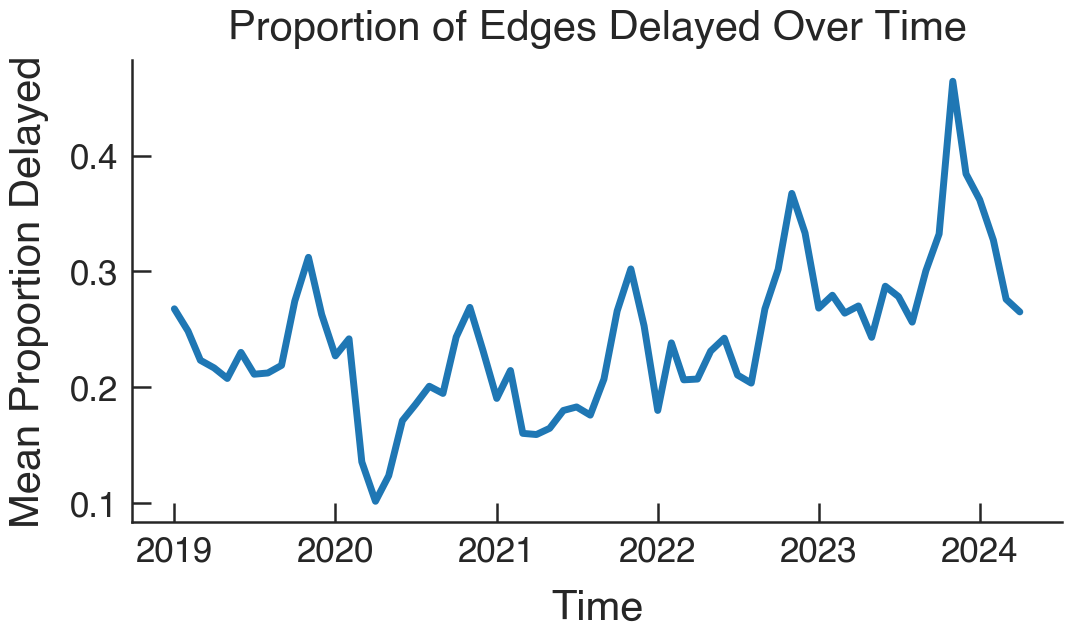

In [8]:
# PROPORTION DELAYED
# Load your dataset
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Ensure 'YearMonth' is in datetime format
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Group by 'YearMonth' and calculate the mean 'Proportion delayed' for each month
monthly_mean_delayed = data.groupby('YearMonth')['Proportion delayed'].mean().reset_index()

# Ensure data is sorted by 'YearMonth'
monthly_mean_delayed = monthly_mean_delayed.sort_values(by='YearMonth')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_mean_delayed['YearMonth'], monthly_mean_delayed['Proportion delayed'], label='Proportion delayed')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Mean Proportion Delayed')
ax.set_title('Proportion of Edges Delayed Over Time')
plt.show()

In [18]:
overall_mean_proportion_delayed = data['Proportion delayed'].mean()
print(f"Overall mean proportion of delayed edges: {overall_mean_proportion_delayed:.4f}")

Overall mean proportion of delayed edges: 0.2454


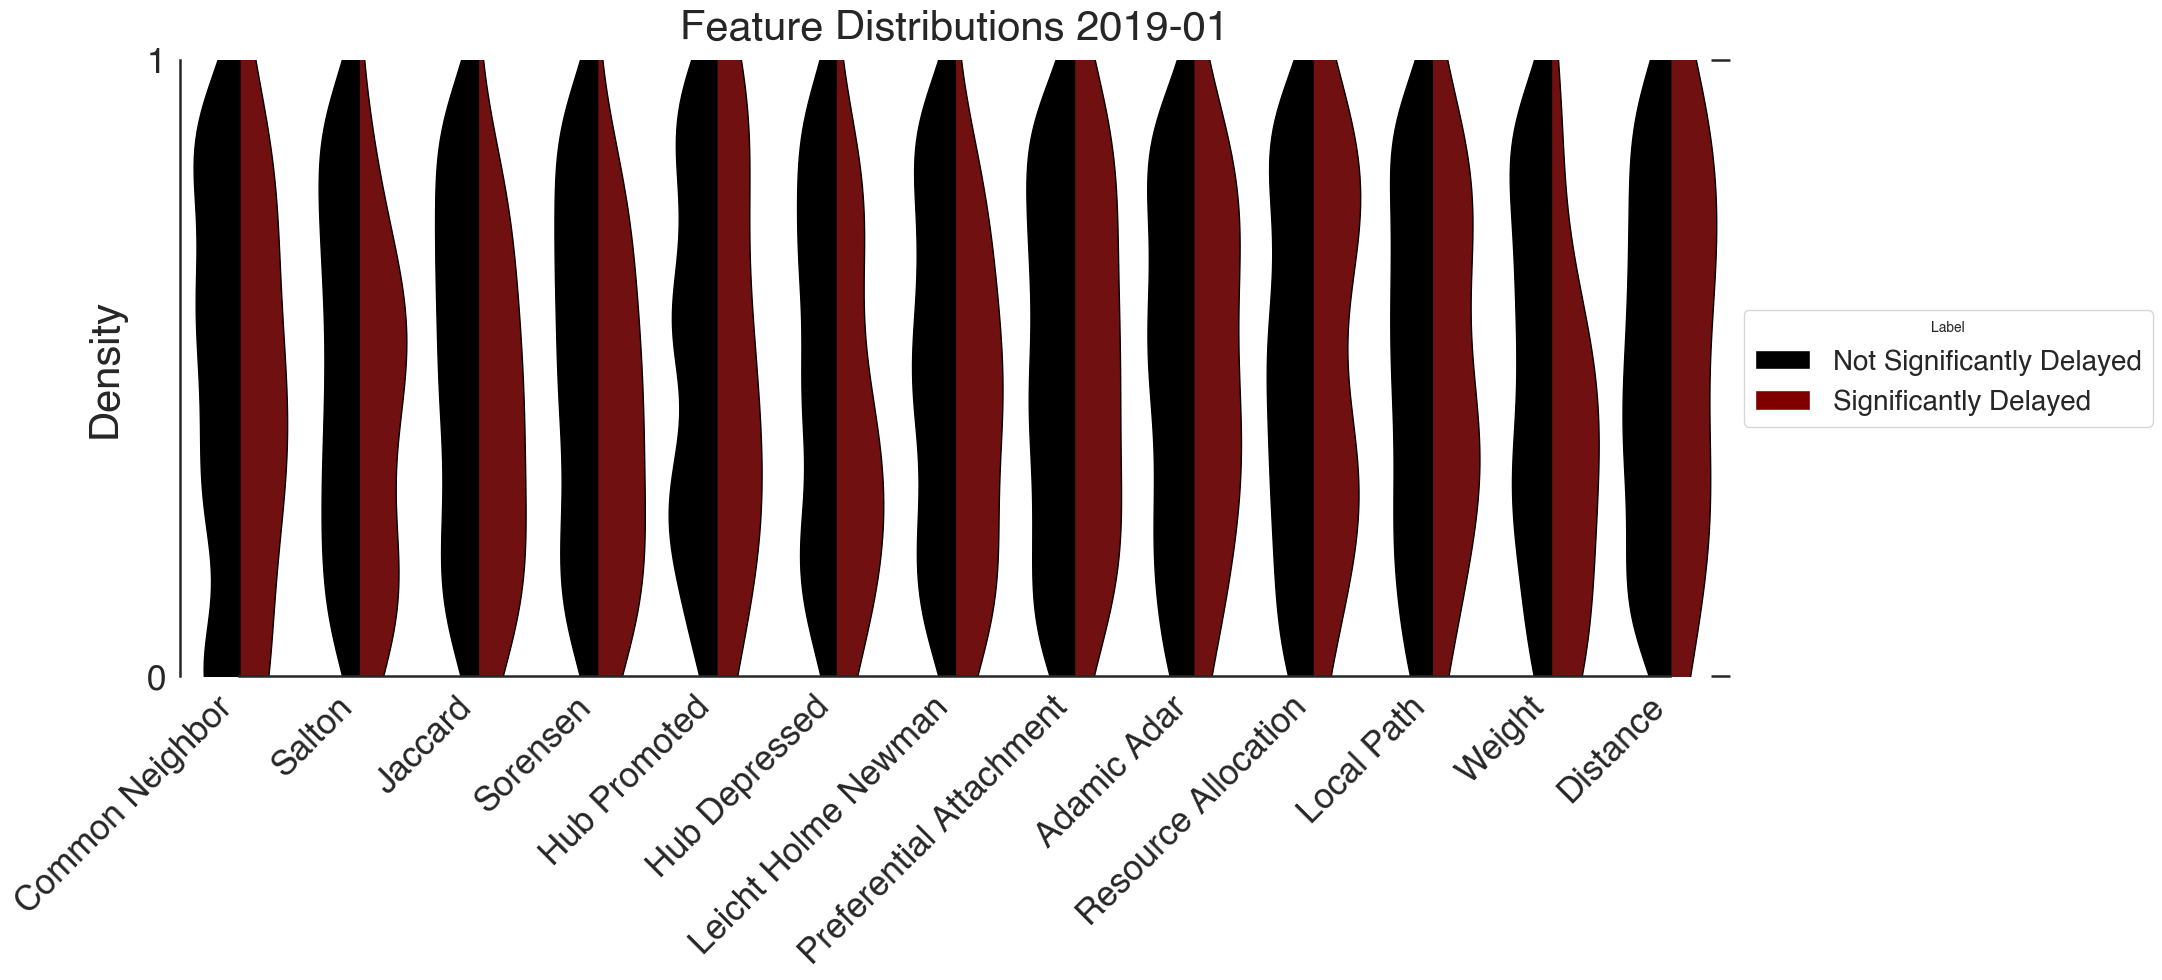

In [20]:
# FEATURE DISTRIBUTION
# Load your dataset
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# Filter data for March 2024
date_data = data[(data['YearMonth'].dt.year == 2019) & (data['YearMonth'].dt.month == 1)]

# Split the dataset into training and testing set based on edges
def get_edge_slice(data, f_train_e=0.7, seed=30):
    edges = list(zip(data['source'], data['target']))  # Get unique edges as tuples of (source, target)
    random.seed(seed)  # Set the random seed for reproducibility
    edge_train = set(random.sample(edges, int(f_train_e * len(edges))))  # Randomly select training edges
    edge_test = set(edges) - edge_train  # The rest are testing edges
    df_train = data[data.apply(lambda row: (row['source'], row['target']) in edge_train, axis=1)].drop(columns=['source', 'target'])  # Training set
    df_test = data[data.apply(lambda row: (row['source'], row['target']) in edge_test, axis=1)].drop(columns=['source', 'target'])  # Testing set
    return df_train, df_test

# Get the training set
train_data, _ = get_edge_slice(date_data)

# List of topological features and their full names
topological_features = {
    'CN': 'Common Neighbor', 
    'SA': 'Salton', 
    'JA': 'Jaccard', 
    'SO': 'Sorensen', 
    'HPI': 'Hub Promoted', 
    'HDI': 'Hub Depressed', 
    'LHNI': 'Leicht Holme Newman', 
    'PA': 'Preferential Attachment', 
    'AA': 'Adamic Adar', 
    'RA': 'Resource Allocation', 
    'LPI': 'Local Path',
    'Rides planned': 'Weight', # Adding 'weight' as 'Rides Planned'
    'distance': 'Distance'
}

# Transform features to range [0, 1] using quantiles
features_to_transform = list(topological_features.keys())
train_data[features_to_transform] = quantile_transform(train_data[features_to_transform], n_quantiles=10, output_distribution='uniform')

# Separate the data based on 'Significant Delay'
delayed_edges = train_data[train_data['Significant Delay'] == True]
not_delayed_edges = train_data[train_data['Significant Delay'] == False]

# Prepare the data for plotting
plot_data = []
for feature, feature_name in topological_features.items():
    for label, subset in [('Not Delayed', not_delayed_edges), ('Delayed', delayed_edges)]:
        for value in subset[feature]:
            plot_data.append({'Feature': feature_name, 'Value': value, 'Label': label})

plot_df = pd.DataFrame(plot_data)

# Set up the plot
plt.figure(figsize=(20, 8))
sns.violinplot(data=plot_df, x='Feature', y='Value', hue='Label', split=True, inner=None, palette={"Not Delayed": "black", "Delayed": "#800000"}, linewidth=1)
plt.ylim(0, 1)
plt.title('Feature Distributions 2019-01')
plt.ylabel('Density')
plt.xlabel('')

# Adjust x-axis labels to diagonal
plt.xticks(rotation=45, ha='right')

legend_labels = [Patch(facecolor='black', label='Not Significantly Delayed'), Patch(facecolor='#800000', label='Significantly Delayed')]
plt.legend(handles=legend_labels, title='Label', loc='center left', bbox_to_anchor=(1, 0.5))


# Only show 0 and 1 on the y-axis
plt.yticks([0, 1], [0, 1])

# Add the bottom x-axis and left y-axis lines
sns.despine(trim=True)

plt.show()


In [10]:
# Extend the analysis to multiple months
import pandas as pd
import random
from sklearn.preprocessing import quantile_transform
from scipy.stats import ks_2samp

# Load your dataset
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# List of topological features and their full names
topological_features = {
    'CN': 'Common Neighbor', 
    'SA': 'Salton', 
    'JA': 'Jaccard', 
    'SO': 'Sorensen', 
    'HPI': 'Hub Promoted', 
    'HDI': 'Hub Depressed', 
    'LHNI': 'Leicht Holme Newman', 
    'PA': 'Preferential Attachment', 
    'AA': 'Adamic Adar', 
    'RA': 'Resource Allocation', 
    'LPI': 'Local Path',
    'Rides planned': 'weight',  # Adding 'weight' as 'Rides Planned'
    'distance': 'Distance'
}

features_to_transform = list(topological_features.keys())

# Initialize lists to store results
all_p_values = []
all_means_delayed = []
all_means_not_delayed = []
all_months = []

# Loop over each month in the data
for year in range(2019, 2025):
    for month in range(1, 13):
        # Filter data for the specific month
        month_data = data[(data['YearMonth'].dt.year == year) & (data['YearMonth'].dt.month == month)]
        
        if month_data.empty:
            continue
        
        # Split the dataset into training and testing set based on edges
        train_data, _ = get_edge_slice(month_data)

        if train_data.empty:
            continue

        # Transform features to range [0, 1] using quantiles
        train_data[features_to_transform] = quantile_transform(train_data[features_to_transform], n_quantiles=10, output_distribution='uniform')
        
        # Separate the data based on 'Significant Delay'
        delayed_edges = train_data[train_data['Significant Delay'] == True]
        not_delayed_edges = train_data[train_data['Significant Delay'] == False]

        # Perform Kolmogorov-Smirnov test for each feature
        p_values = []
        means_delayed = []
        means_not_delayed = []
        for feature in features_to_transform:
            ks_statistic, p_value = ks_2samp(delayed_edges[feature], not_delayed_edges[feature])
            p_values.append(p_value)
            means_delayed.append(delayed_edges[feature].mean())
            means_not_delayed.append(not_delayed_edges[feature].mean())
        
        # Append results to the lists
        all_p_values.append(p_values)
        all_means_delayed.append(means_delayed)
        all_means_not_delayed.append(means_not_delayed)
        all_months.append(f"{year}-{month:02d}")

# Convert results to DataFrame
results_df = pd.DataFrame(all_p_values, columns=features_to_transform)
results_df['Month'] = all_months

# Apply Bonferroni correction
alpha = 0.05 / len(features_to_transform)
results_df['Significant'] = results_df[features_to_transform].apply(lambda row: any(row < alpha), axis=1)

# Print the results
results_df

,CN,SA,JA,SO,HPI,HDI,LHNI,PA,AA,RA,LPI,Rides planned,distance,Month,Significant
0,0.927355,0.116162,0.280697,0.280697,0.999945,0.212627,0.471406,0.990869,0.975915,0.732253,0.850134,0.030631,0.732253,2019-01,False
1,0.394540,0.715681,0.644265,0.644265,0.761249,0.769195,0.989068,0.667515,0.599611,0.721865,0.537328,0.161725,0.991439,2019-02,False
2,0.251295,0.263157,0.251295,0.251295,0.889770,0.182115,0.190434,0.215588,0.166136,0.704604,0.285773,0.001846,0.968140,2019-03,True
3,0.538240,0.658290,0.290522,0.290522,0.451367,0.762708,0.147448,0.040723,0.217223,0.462763,0.191612,0.017199,0.323036,2019-04,False
4,0.858432,0.516394,0.780830,0.780830,0.840053,0.759782,0.716314,0.369042,0.505227,0.716314,0.463834,0.116278,0.908156,2019-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.289803,0.390020,0.398650,0.398650,0.464400,0.199515,0.112472,0.332833,0.270148,0.252938,0.270148,0.000024,0.041540,2023-12,True
60,0.860530,0.411949,0.529734,0.529734,0.999374,0.154023,0.297349,0.555596,0.826115,0.442304,0.857847,0.077512,0.238072,2024-01,False
61,0.999964,0.472624,0.422936,0.422936,0.717998,0.705201,0.314059,0.821503,0.863659,0.499450,0.776842,0.268524,0.166011,2024-02,False
62,0.986600,0.593083,0.595576,0.595576,0.371394,0.836263,0.107294,0.666134,0.593083,0.648868,0.695095,0.327701,0.139031,2024-03,False


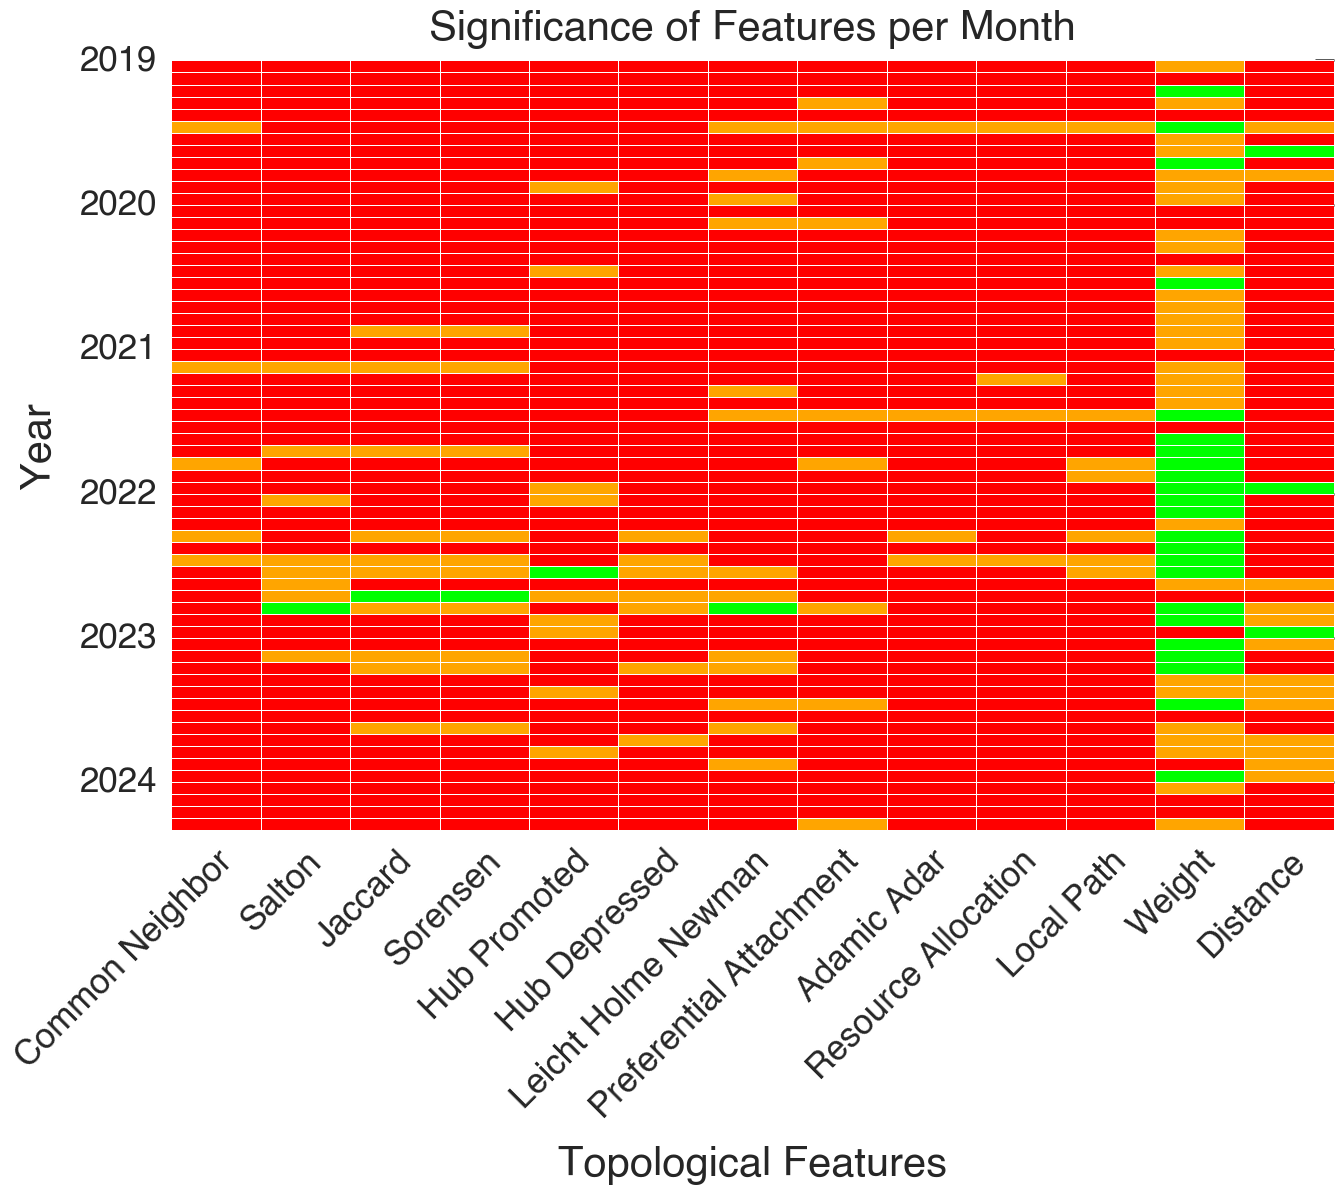

In [11]:
# HEATMAP FEATURES
# Load your dataset
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# List of topological features and their full names
topological_features = {
    'CN': 'Common Neighbor', 
    'SA': 'Salton', 
    'JA': 'Jaccard', 
    'SO': 'Sorensen', 
    'HPI': 'Hub Promoted', 
    'HDI': 'Hub Depressed', 
    'LHNI': 'Leicht Holme Newman', 
    'PA': 'Preferential Attachment', 
    'AA': 'Adamic Adar', 
    'RA': 'Resource Allocation', 
    'LPI': 'Local Path',
    'Rides planned': 'Weight',  # Adding 'weight' as 'Rides Planned'
    'distance': 'Distance'
}

# Ensure the order of features
ordered_features = [
    'Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 
    'Hub Promoted', 'Hub Depressed', 'Leicht Holme Newman', 
    'Preferential Attachment', 'Adamic Adar', 'Resource Allocation', 
    'Local Path', 'Weight', 'Distance'
]

features_to_transform = list(topological_features.keys())

# Initialize lists to store results
all_p_values = []
all_means_delayed = []
all_means_not_delayed = []
all_months = []

# Loop over each month in the data
for year in range(2019, 2025):
    for month in range(1, 13):
        # Filter data for the specific month
        month_data = data[(data['YearMonth'].dt.year == year) & (data['YearMonth'].dt.month == month)]
        
        if month_data.empty:
            continue
        
        # Split the dataset into training and testing set based on edges
        train_data, _ = get_edge_slice(month_data)

        if train_data.empty:
            continue

        # Transform features to range [0, 1] using quantiles
        train_data[features_to_transform] = quantile_transform(train_data[features_to_transform], n_quantiles=10, output_distribution='uniform')
        
        # Separate the data based on 'Significant Delay'
        delayed_edges = train_data[train_data['Significant Delay'] == True]
        not_delayed_edges = train_data[train_data['Significant Delay'] == False]

        # Perform Kolmogorov-Smirnov test for each feature
        p_values = []
        means_delayed = []
        means_not_delayed = []
        for feature in features_to_transform:
            ks_statistic, p_value = ks_2samp(delayed_edges[feature], not_delayed_edges[feature])
            p_values.append(p_value)
            means_delayed.append(delayed_edges[feature].mean())
            means_not_delayed.append(not_delayed_edges[feature].mean())
        
        # Append results to the lists
        all_p_values.append(p_values)
        all_means_delayed.append(means_delayed)
        all_means_not_delayed.append(means_not_delayed)
        all_months.append(f"{year}-{month:02d}")

# Convert results to DataFrame
p_values_df = pd.DataFrame(all_p_values, columns=features_to_transform)
p_values_df['Month'] = all_months

# Apply Bonferroni correction
alpha = 0.05 / len(features_to_transform)
p_values_df['Significant'] = p_values_df[features_to_transform].apply(lambda row: any(row < alpha), axis=1)

# Define significance levels as numerical values
def significance_level(p):
    if p < alpha:
        return 1  # Significant
    elif p < 0.1:  # Close to significant
        return 0.5
    else:
        return 0  # Not significant

# Apply numerical coding
for feature in features_to_transform:
    p_values_df[feature] = p_values_df[feature].apply(significance_level)

# Melt the DataFrame for easier plotting with seaborn
melted_df = p_values_df.melt(id_vars=['Month'], value_vars=features_to_transform, var_name='Feature', value_name='Significance')

# Replace feature short names with full names
melted_df['Feature'] = melted_df['Feature'].map(topological_features)

# Pivot the DataFrame to get months as rows and features as columns
pivot_df = melted_df.pivot(index='Month', columns='Feature', values='Significance')

# Reorder the columns
pivot_df = pivot_df[ordered_features]

# Extract unique years from the Month column for labeling
unique_years = sorted(set(pivot_df.index.str[:4]))

# Create a custom colormap
cmap = sns.color_palette(['#FF0000', '#FFA500', '#00FF00'])

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)
plt.xticks(rotation=45, ha='right', va='top', rotation_mode='anchor')
plt.yticks(ticks=[i for i in range(len(pivot_df)) if i % 12 == 0], labels=unique_years, rotation=0)
plt.xlabel('Topological Features')
plt.ylabel('Year')
plt.title('Significance of Features per Month')
plt.show()

In [12]:
# Initialize lists to store results
all_p_values = []
all_means_delayed = []
all_means_not_delayed = []
all_months = []

# Loop over each month in the data
for year in range(2019, 2025):
    for month in range(1, 13):
        # Filter data for the specific month
        month_data = data[(data['YearMonth'].dt.year == year) & (data['YearMonth'].dt.month == month)]
        
        if month_data.empty:
            continue
        
        # Split the dataset into training and testing set based on edges
        train_data, _ = get_edge_slice(month_data)

        if train_data.empty:
            continue

        # Transform features to range [0, 1] using quantiles
        train_data[features_to_transform] = quantile_transform(train_data[features_to_transform], n_quantiles=10, output_distribution='uniform')
        
        # Separate the data based on 'Significant Delay'
        delayed_edges = train_data[train_data['Significant Delay'] == True]
        not_delayed_edges = train_data[train_data['Significant Delay'] == False]

        # Perform Kolmogorov-Smirnov test for each feature
        p_values = []
        means_delayed = []
        means_not_delayed = []
        for feature in features_to_transform:
            ks_statistic, p_value = ks_2samp(delayed_edges[feature], not_delayed_edges[feature])
            p_values.append(p_value)
            means_delayed.append(delayed_edges[feature].mean())
            means_not_delayed.append(not_delayed_edges[feature].mean())
        
        # Append results to the lists
        all_p_values.append(p_values)
        all_means_delayed.append(means_delayed)
        all_means_not_delayed.append(means_not_delayed)
        all_months.append(f"{year}-{month:02d}")

# Convert results to DataFrame
p_values_df = pd.DataFrame(all_p_values, columns=features_to_transform)
means_delayed_df = pd.DataFrame(all_means_delayed, columns=features_to_transform)
means_not_delayed_df = pd.DataFrame(all_means_not_delayed, columns=features_to_transform)
p_values_df['Month'] = all_months
means_delayed_df['Month'] = all_months
means_not_delayed_df['Month'] = all_months

# Aggregate p-values using Fisher's combined probability test
combined_p_values = {}
for feature in features_to_transform:
    p_values = p_values_df[feature].dropna().values  # Remove NaN values
    if len(p_values) > 0:
        stat, combined_p_value = combine_pvalues(p_values, method='fisher')
    else:
        combined_p_value = np.nan
    combined_p_values[feature] = combined_p_value

# Calculate mean values over multiple months
mean_delayed = means_delayed_df[features_to_transform].mean()
mean_not_delayed = means_not_delayed_df[features_to_transform].mean()

# Apply Bonferroni correction
alpha = 0.05 / len(features_to_transform)
significant = {feature: p_value < alpha for feature, p_value in combined_p_values.items()}

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Feature': features_to_transform,
    'Mean_Delayed': mean_delayed.values,
    'Mean_Not_Delayed': mean_not_delayed.values,
    'P_Value': [combined_p_values[feature] for feature in features_to_transform],
    'Significant': [significant[feature] for feature in features_to_transform]
})
summary_df

,Feature,Mean_Delayed,Mean_Not_Delayed,P_Value,Significant
0,CN,0.454274,0.471337,9.994016e-01,False
1,SA,0.457984,0.502046,3.661991e-03,True
2,JA,0.461537,0.499488,3.357050e-02,False
3,SO,0.462095,0.500163,3.357050e-02,False
4,HPI,0.456884,0.505413,2.134418e-01,False
5,HDI,0.464137,0.499367,3.363588e-01,False
6,LHNI,0.458515,0.501279,2.634264e-04,True
7,PA,0.500567,0.493578,6.635270e-01,False
8,AA,0.488431,0.492837,8.728983e-01,False
9,RA,0.491922,0.492589,9.862902e-01,False


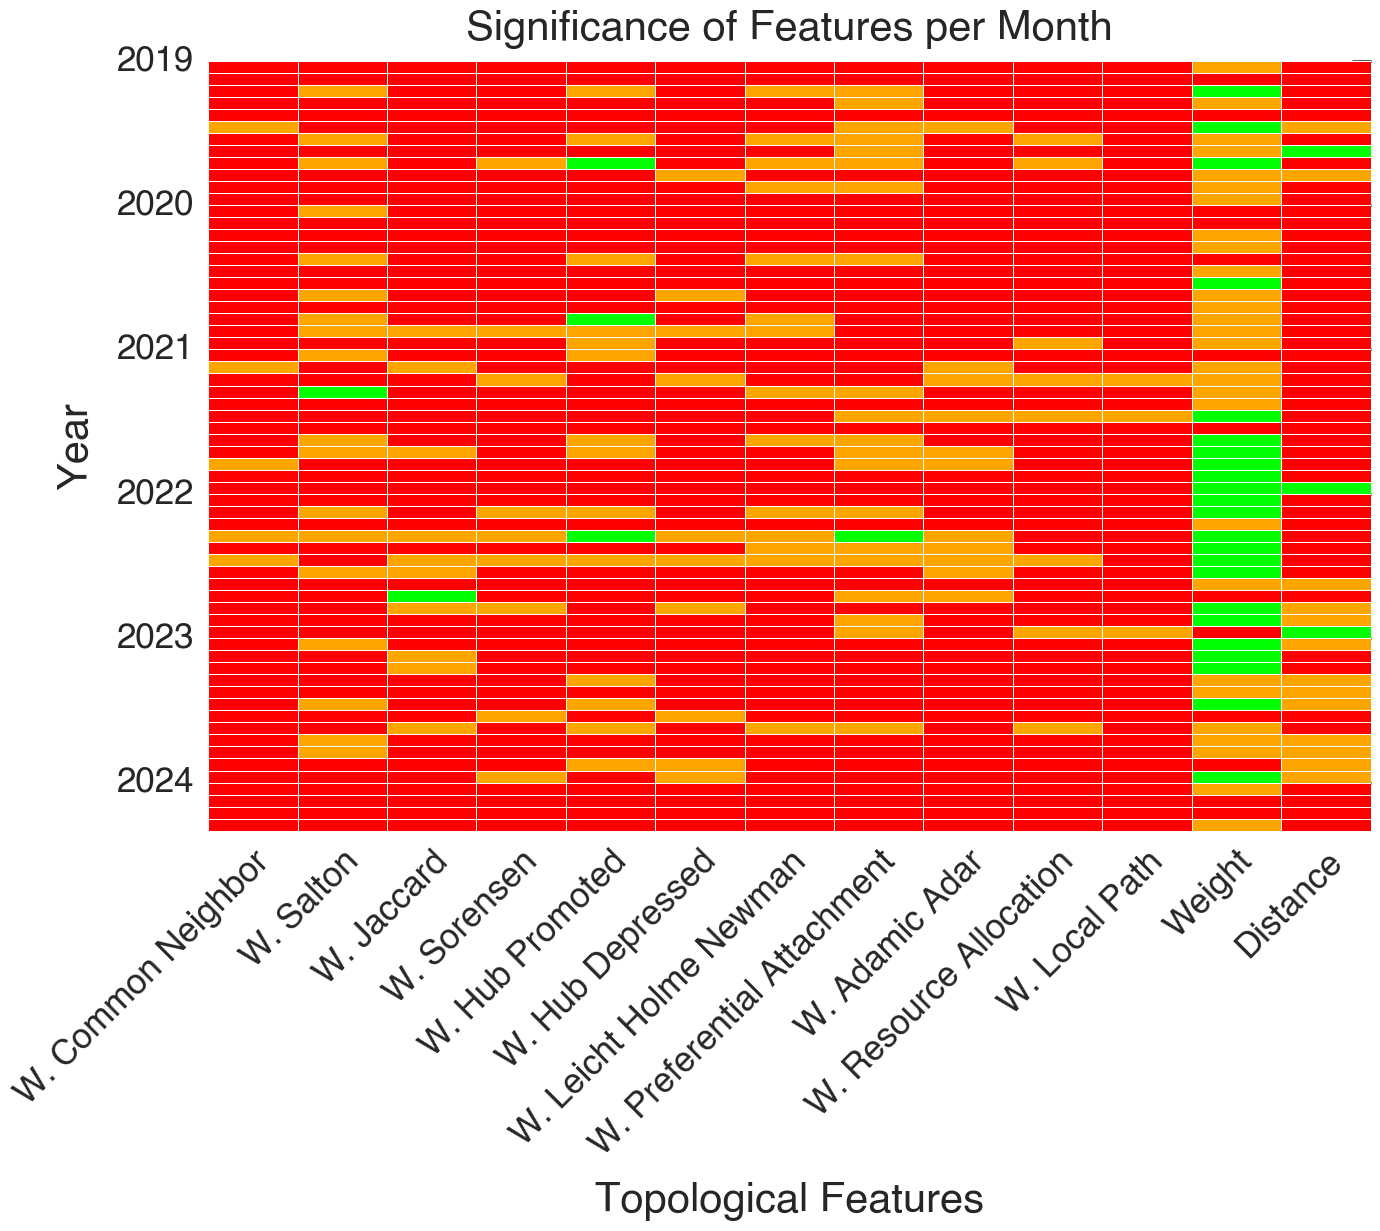

In [92]:
# HEATMAP WEIGHTED TOPOLOGICAL FEATURES
# Load your dataset
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format
data['YearMonth'] = pd.to_datetime(data['YearMonth'])

# List of topological features and their full names
topological_features = {
    'weighted_CN': 'W. Common Neighbor', 
    'weighted_SA': 'W. Salton', 
    'weighted_JA': 'W. Jaccard', 
    'weighted_SO': 'W. Sorensen', 
    'weighted_HPI': 'W. Hub Promoted', 
    'weighted_HDI': 'W. Hub Depressed', 
    'weighted_LHNI': 'W. Leicht Holme Newman', 
    'weighted_PA': 'W. Preferential Attachment', 
    'weighted_AA': 'W. Adamic Adar', 
    'weighted_RA': 'W. Resource Allocation', 
    'weighted_LPI': 'W. Local Path',
    'Rides planned': 'Weight',  # Adding 'weight' as 'Rides Planned'
    'distance': 'Distance'
}

# Ensure the order of features
ordered_features = [
    'W. Common Neighbor', 'W. Salton', 'W. Jaccard', 'W. Sorensen', 
    'W. Hub Promoted', 'W. Hub Depressed', 'W. Leicht Holme Newman', 
    'W. Preferential Attachment', 'W. Adamic Adar', 'W. Resource Allocation', 
    'W. Local Path', 'Weight', 'Distance'
]

features_to_transform = list(topological_features.keys())

# Initialize lists to store results
all_p_values = []
all_means_delayed = []
all_means_not_delayed = []
all_months = []

# Loop over each month in the data
for year in range(2019, 2025):
    for month in range(1, 13):
        # Filter data for the specific month
        month_data = data[(data['YearMonth'].dt.year == year) & (data['YearMonth'].dt.month == month)]
        
        if month_data.empty:
            continue
        
        # Split the dataset into training and testing set based on edges
        train_data, _ = get_edge_slice(month_data)

        if train_data.empty:
            continue

        # Transform features to range [0, 1] using quantiles
        train_data[features_to_transform] = quantile_transform(train_data[features_to_transform], n_quantiles=10, output_distribution='uniform')
        
        # Separate the data based on 'Significant Delay'
        delayed_edges = train_data[train_data['Significant Delay'] == True]
        not_delayed_edges = train_data[train_data['Significant Delay'] == False]

        # Perform Kolmogorov-Smirnov test for each feature
        p_values = []
        means_delayed = []
        means_not_delayed = []
        for feature in features_to_transform:
            ks_statistic, p_value = ks_2samp(delayed_edges[feature], not_delayed_edges[feature])
            p_values.append(p_value)
            means_delayed.append(delayed_edges[feature].mean())
            means_not_delayed.append(not_delayed_edges[feature].mean())
        
        # Append results to the lists
        all_p_values.append(p_values)
        all_means_delayed.append(means_delayed)
        all_means_not_delayed.append(means_not_delayed)
        all_months.append(f"{year}-{month:02d}")

# Convert results to DataFrame
p_values_df = pd.DataFrame(all_p_values, columns=features_to_transform)
p_values_df['Month'] = all_months

# Apply Bonferroni correction
alpha = 0.05 / len(features_to_transform)
p_values_df['Significant'] = p_values_df[features_to_transform].apply(lambda row: any(row < alpha), axis=1)

# Define significance levels as numerical values
def significance_level(p):
    if p < alpha:
        return 1  # Significant
    elif p < 0.1:  # Close to significant
        return 0.5
    else:
        return 0  # Not significant

# Apply numerical coding
for feature in features_to_transform:
    p_values_df[feature] = p_values_df[feature].apply(significance_level)

# Melt the DataFrame for easier plotting with seaborn
melted_df = p_values_df.melt(id_vars=['Month'], value_vars=features_to_transform, var_name='Feature', value_name='Significance')

# Replace feature short names with full names
melted_df['Feature'] = melted_df['Feature'].map(topological_features)

# Pivot the DataFrame to get months as rows and features as columns
pivot_df = melted_df.pivot(index='Month', columns='Feature', values='Significance')

# Reorder the columns
pivot_df = pivot_df[ordered_features]

# Extract unique years from the Month column for labeling
unique_years = sorted(set(pivot_df.index.str[:4]))

# Create a custom colormap
cmap = sns.color_palette(['#FF0000', '#FFA500', '#00FF00'])

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5)
plt.xticks(rotation=45, ha='right', va='top', rotation_mode='anchor')
plt.yticks(ticks=[i for i in range(len(pivot_df)) if i % 12 == 0], labels=unique_years, rotation=0)
plt.xlabel('Topological Features')
plt.ylabel('Year')
plt.title('Significance of Features per Month')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/merelkamper/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/merelkamper/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/merelkamper/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/merelkamper/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (

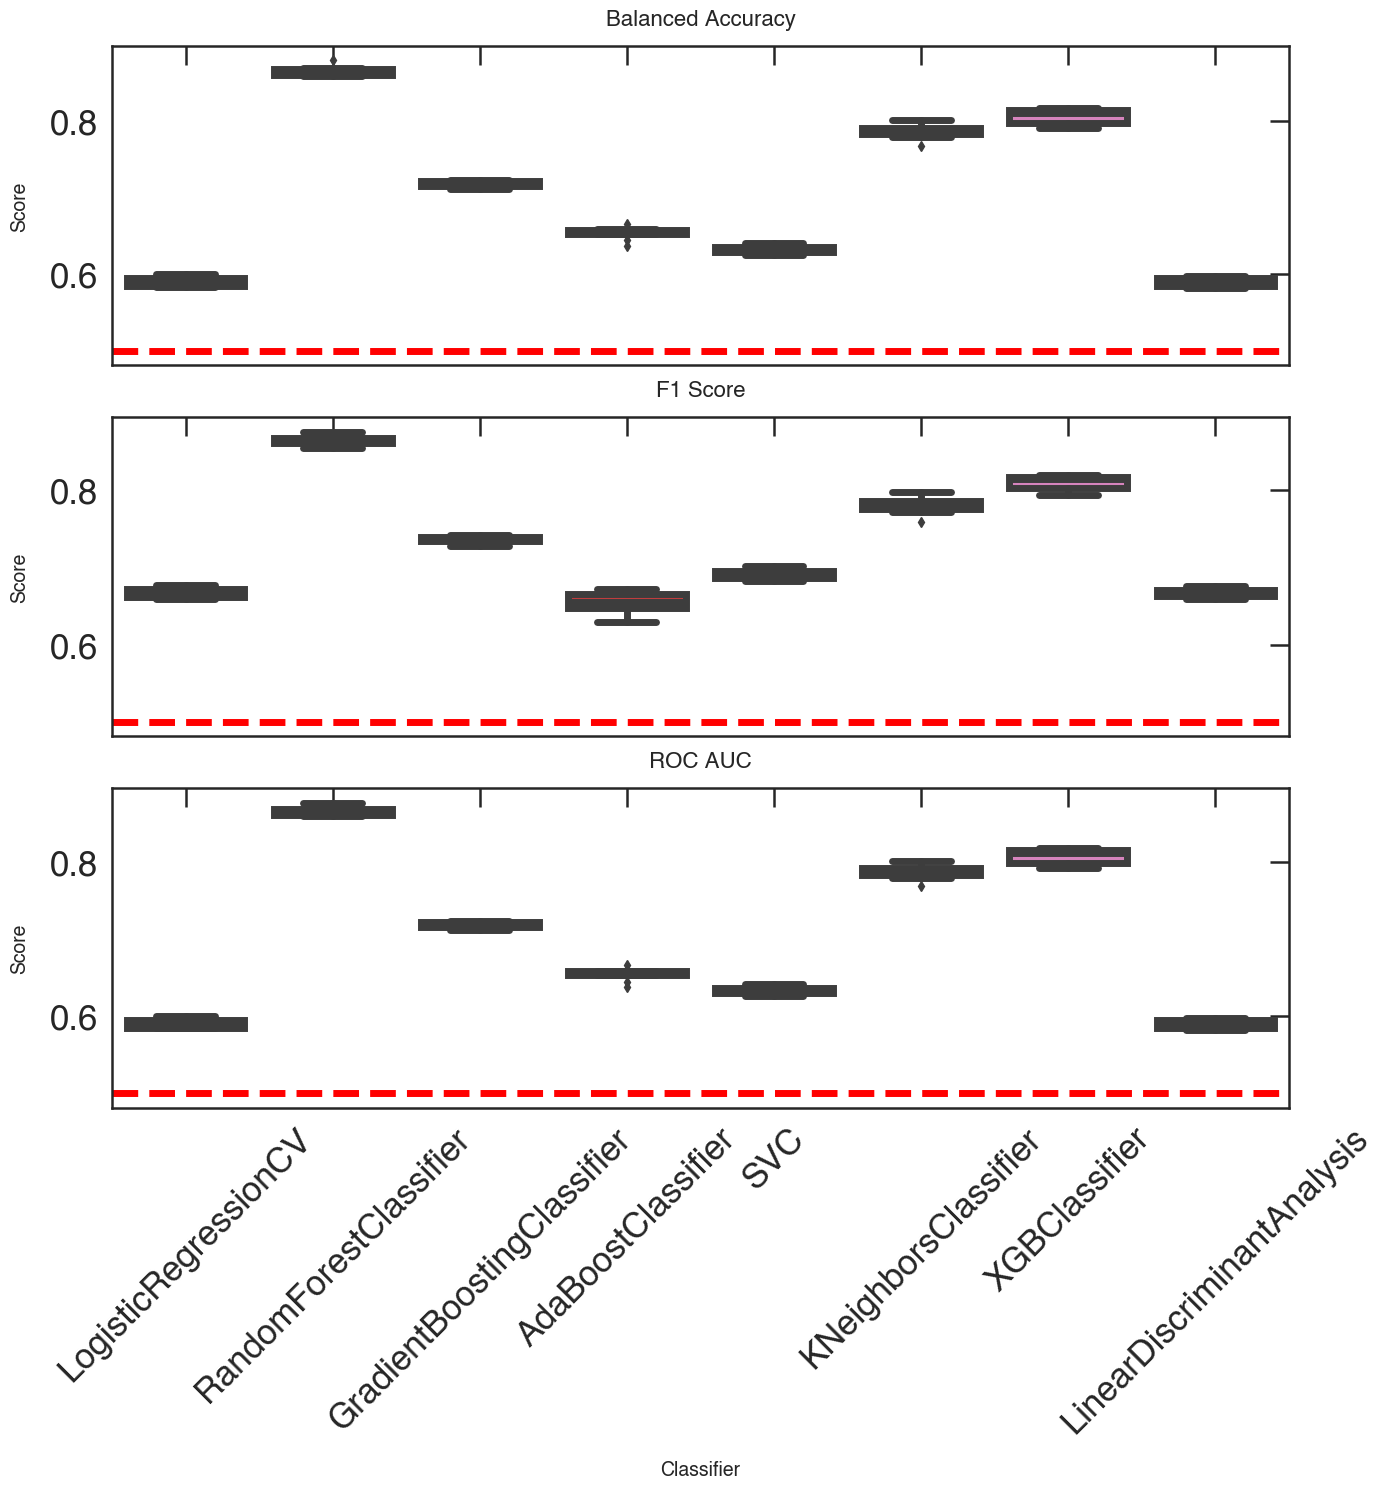

In [17]:
# Load dataset
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc-Thesis-main/adapted/data/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format and drop the original column
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data = data.drop(columns=['YearMonth'])

# List of topological features
topological_features = ['Rides planned', 'distance']

# Use topological features as well as 'Rides planned' and 'distance'
X = data[topological_features]
y = data['Significant Delay']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance the training set using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define classifiers
classifiers = {
    'LogisticRegressionCV': LogisticRegressionCV(cv=5, max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'SVC': SVC(probability=True),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis()
}

# Define scoring functions
scoring = {
    'Balanced Accuracy': make_scorer(balanced_accuracy_score),
    'F1 Score': make_scorer(f1_score),
    'ROC AUC': make_scorer(roc_auc_score)
}

results = {name: {'Balanced Accuracy': [], 'F1 Score': [], 'ROC AUC': []} for name in classifiers.keys()}

# Perform 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  

def evaluate_classifier(name, clf, scoring, X_train_balanced, y_train_balanced, skf):
    clf_results = {metric: [] for metric in scoring.keys()}
    for metric in scoring.keys():
        scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=skf, scoring=scoring[metric], n_jobs=-1)
        clf_results[metric].extend(scores)
    return name, clf_results

# Use parallel processing to speed up evaluation
parallel = Parallel(n_jobs=-1, verbose=1)
results_list = parallel(delayed(evaluate_classifier)(name, clf, scoring, X_train_balanced, y_train_balanced, skf)
                        for name, clf in classifiers.items())

# Convert results to a dictionary
for name, clf_results in results_list:
    results[name] = clf_results

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame([
    [clf, metric, score]
    for clf, metrics in results.items()
    for metric, scores in metrics.items()
    for score in scores
], columns=['Classifier', 'Metric', 'Score'])

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15), sharex=True)

metrics = ['Balanced Accuracy', 'F1 Score', 'ROC AUC']
for i, metric in enumerate(metrics):
    sns.boxplot(x='Classifier', y='Score', data=results_df[results_df['Metric'] == metric], ax=axes[i])
    axes[i].axhline(y=0.5, color='red', linestyle='--')  # Baseline
    axes[i].set_title(metric, fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Score', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# Only set x-axis label for the bottom plot
axes[-1].set_xlabel('Classifier', fontsize=14)

plt.tight_layout()
plt.show()

### Original code

In [7]:
data = pd.read_pickle('../results/us_air_data_binary_removal_dl.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
data = data[data.year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data_air = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']

data_air =  data_air[columns].rename(columns=rename_again)

In [ ]:
# import essential packages
import cartopy.crs as ccrs
import cartopy as cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.lines import Line2D

In [13]:
#function to convert node name to readable form
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])


#nodes position information
def plot_air_network(facecolor='#f0f0f0'):
    pos = pd.read_pickle('../data/US_air_geo_information.pkl')

    #prepare labels for edges
    labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
    colors = ['black', 'red']
    styles = ['solid', 'dashed']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

    #select snapshot for displaying 
    year = date(2014,1,1)
    G = graphs_air[date_air.index(year)]
    H = graphs_air[date_air.index(year) + 1]

    #edges separation
    ## the edges that are in mainland us
    edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
    edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]

    # border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
    border = [-119,-74,23,50]
    central_lon = np.mean(border[:2])
    central_lat = np.mean(border[2:])

    fig = plt.figure(figsize=(xs,ys),frameon=False)
    ax = fig.add_subplot(1,1,1,projection=ccrs.AlbersEqualArea(central_lon, central_lat))

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
    shp = shapereader.Reader(states_shp)
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    for record, state in zip(shp.records(), shp.geometries()):
        name = record.attributes['name']
        facecolor = facecolor #'#faf2dd' #'#f0f0f0'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor='none',zorder=-1)
    ax.set_extent(border)
    # ax.set_xlim(-125,-67)
    # ax.set_ylim(20,50)
    # draw edges
    draw(G,
            pos = pos,
            width= 0.1,
            alpha= 0.15,
            node_size = 0,
            edgelist= edges_in_land,
            edge_color = 'black',
            style = 'solid',ax=ax)

    # draw nodes
    draw(G,
            pos = pos,
            node_color = '#377eb8',
            width= 0,
            alpha= 1,
            node_size = np.array(list(dict(G.degree()).values()))/0.5)

    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    ax.set_title('US Air - DL (Jan. 2014)')
    plt.savefig(f'../figures/Fig.1B_DL.png',bbox_inches='tight',dpi=200,transparent=True)
    plt.show()

In [11]:
import warnings
warnings.simplefilter(action='ignore')

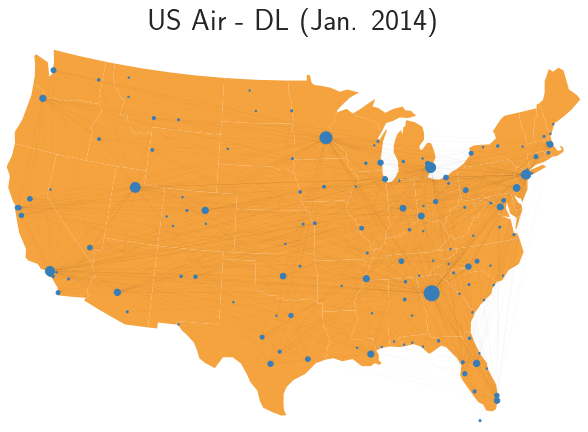

In [74]:
plot_air_network(facecolor='#f5a33e')

In [4]:
from numbers import Number
import networkx as nx
from networkx.utils import is_string_like
from networkx.drawing.layout import shell_layout, \
    circular_layout, kamada_kawai_layout, spectral_layout, \
    spring_layout, random_layout, planar_layout

__all__ = ['draw',
           'draw_networkx',
           'draw_networkx_nodes',
           'draw_networkx_edges',
           'draw_networkx_labels',
           'draw_networkx_edge_labels',
           'draw_circular',
           'draw_kamada_kawai',
           'draw_random',
           'draw_spectral',
           'draw_spring',
           'draw_planar',
           'draw_shell']


def draw(G, pos=None, ax=None, **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        cf = plt.gcf()
    else:
        cf = ax.get_figure()
    cf.set_facecolor('w')
    if ax is None:
        if cf._axstack() is None:
            ax = cf.add_axes((0, 0, 1, 1))
        else:
            ax = cf.gca()

    if 'with_labels' not in kwds:
        kwds['with_labels'] = 'labels' in kwds

    draw_networkx(G, pos=pos, ax=ax, **kwds)
    ax.set_axis_off()
    plt.draw_if_interactive()
    return



def draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if pos is None:
        pos = nx.drawing.spring_layout(G)  # default to spring layout

    node_collection = draw_networkx_nodes(G, pos, **kwds)
    edge_collection = draw_networkx_edges(G, pos, arrows=arrows, **kwds)
    if with_labels:
        draw_networkx_labels(G, pos, **kwds)
    plt.draw_if_interactive()



def draw_networkx_nodes(G, pos,
                        nodelist=None,
                        node_size=300,
                        node_color='#1f78b4',
                        node_shape='o',
                        alpha=None,
                        cmap=None,
                        vmin=None,
                        vmax=None,
                        ax=None,
                        linewidths=None,
                        edgecolors=None,
                        label=None,
                        **kwds):

    from collections.abc import Iterable
    try:
        import matplotlib.pyplot as plt
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if nodelist is None:
        nodelist = list(G)

    if len(nodelist) == 0:  # empty nodelist, no drawing
        return

    try:
        xy = np.asarray([pos[v] for v in nodelist])
    except KeyError as e:
        raise nx.NetworkXError('Node %s has no position.' % e)
    except ValueError:
        raise nx.NetworkXError('Bad value in node positions.')

    if isinstance(alpha, Iterable):
        node_color = apply_alpha(node_color, alpha, nodelist, cmap, vmin, vmax)
        alpha = None

    node_collection = ax.scatter(xy[:, 0], xy[:, 1],
                                 s=node_size,
                                 c=node_color,
                                 marker=node_shape,
                                 cmap=cmap,
                                 vmin=vmin,
                                 vmax=vmax,
                                 alpha=alpha,
                                 linewidths=linewidths,
                                 edgecolors=edgecolors,
                                 label=label,transform=ccrs.Geodetic())
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    node_collection.set_zorder(2)
    return node_collection



def draw_networkx_edges(G, pos,
                        edgelist=None,
                        width=1.0,
                        edge_color='k',
                        style='solid',
                        alpha=None,
                        arrowstyle='-|>',
                        arrowsize=10,
                        edge_cmap=None,
                        edge_vmin=None,
                        edge_vmax=None,
                        ax=None,
                        arrows=True,
                        label=None,
                        node_size=300,
                        nodelist=None,
                        node_shape="o",
                        connectionstyle=None,
                        min_source_margin=0,
                        min_target_margin=0,
                        **kwds):
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.colors import colorConverter, Colormap, Normalize
        from matplotlib.collections import LineCollection
        from matplotlib.patches import FancyArrowPatch
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if edgelist is None:
        edgelist = list(G.edges())

    if not edgelist or len(edgelist) == 0:  # no edges!
        return None

    if nodelist is None:
        nodelist = list(G.nodes())

    # FancyArrowPatch handles color=None different from LineCollection
    if edge_color is None:
        edge_color = 'k'

    # set edge positions
    edge_pos = np.asarray([(pos[e[0]], pos[e[1]]) for e in edgelist])

    # Check if edge_color is an array of floats and map to edge_cmap.
    # This is the only case handled differently from matplotlib
    if np.iterable(edge_color) and (len(edge_color) == len(edge_pos)) \
            and np.alltrue([isinstance(c, Number) for c in edge_color]):
        if edge_cmap is not None:
            assert(isinstance(edge_cmap, Colormap))
        else:
            edge_cmap = plt.get_cmap()
        if edge_vmin is None:
            edge_vmin = min(edge_color)
        if edge_vmax is None:
            edge_vmax = max(edge_color)
        color_normal = Normalize(vmin=edge_vmin, vmax=edge_vmax)
        edge_color = [edge_cmap(color_normal(e)) for e in edge_color]

    if (not G.is_directed() or not arrows):
        edge_collection = LineCollection(edge_pos,
                                         colors=edge_color,
                                         linewidths=width,
                                         antialiaseds=(1,),
                                         linestyle=style,
                                         transOffset=ax.transData,
                                         alpha=alpha,transform=ccrs.Geodetic()
                                         )

        edge_collection.set_zorder(1)  # edges go behind nodes
        edge_collection.set_label(label)
        ax.add_collection(edge_collection)

        return edge_collection

    arrow_collection = None

    if G.is_directed() and arrows:
        # Note: Waiting for someone to implement arrow to intersection with
        # marker.  Meanwhile, this works well for polygons with more than 4
        # sides and circle.

        def to_marker_edge(marker_size, marker):
            if marker in "s^>v<d":  # `large` markers need extra space
                return np.sqrt(2 * marker_size) / 2
            else:
                return np.sqrt(marker_size) / 2

        # Draw arrows with `matplotlib.patches.FancyarrowPatch`
        arrow_collection = []
        mutation_scale = arrowsize  # scale factor of arrow head

        # FancyArrowPatch doesn't handle color strings
        arrow_colors = colorConverter.to_rgba_array(edge_color, alpha)
        for i, (src, dst) in enumerate(edge_pos):
            x1, y1 = src
            x2, y2 = dst
            shrink_source = 0  # space from source to tail
            shrink_target = 0  # space from  head to target
            if np.iterable(node_size):  # many node sizes
                src_node, dst_node = edgelist[i][:2]
                index_node = nodelist.index(dst_node)
                marker_size = node_size[index_node]
                shrink_target = to_marker_edge(marker_size, node_shape)
            else:
                shrink_target = to_marker_edge(node_size, node_shape)

            if shrink_source < min_source_margin:
                shrink_source = min_source_margin

            if shrink_target < min_target_margin:
                shrink_target = min_target_margin

            if len(arrow_colors) == len(edge_pos):
                arrow_color = arrow_colors[i]
            elif len(arrow_colors) == 1:
                arrow_color = arrow_colors[0]
            else:  # Cycle through colors
                arrow_color = arrow_colors[i % len(arrow_colors)]

            if np.iterable(width):
                if len(width) == len(edge_pos):
                    line_width = width[i]
                else:
                    line_width = width[i % len(width)]
            else:
                line_width = width

            arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                    arrowstyle=arrowstyle,
                                    shrinkA=shrink_source,
                                    shrinkB=shrink_target,
                                    mutation_scale=mutation_scale,
                                    color=arrow_color,
                                    linewidth=line_width,
                                    connectionstyle=connectionstyle,
                                    zorder=1)  # arrows go behind nodes

            # There seems to be a bug in matplotlib to make collections of
            # FancyArrowPatch instances. Until fixed, the patches are added
            # individually to the axes instance.
            arrow_collection.append(arrow)
            ax.add_patch(arrow)

    # update view
    minx = np.amin(np.ravel(edge_pos[:, :, 0]))
    maxx = np.amax(np.ravel(edge_pos[:, :, 0]))
    miny = np.amin(np.ravel(edge_pos[:, :, 1]))
    maxy = np.amax(np.ravel(edge_pos[:, :, 1]))

    w = maxx - minx
    h = maxy - miny
    padx,  pady = 0.05 * w, 0.05 * h
    corners = (minx - padx, miny - pady), (maxx + padx, maxy + pady)
    ax.update_datalim(corners)
    ax.autoscale_view()

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return arrow_collection



def draw_networkx_labels(G, pos,
                         labels=None,
                         font_size=12,
                         font_color='k',
                         font_family='sans-serif',
                         font_weight='normal',
                         alpha=None,
                         bbox=None,
                         ax=None,
                         **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = dict((n, n) for n in G.nodes())

    # set optional alignment
    horizontalalignment = kwds.get('horizontalalignment', 'center')
    verticalalignment = kwds.get('verticalalignment', 'center')

    text_items = {}  # there is no text collection so we'll fake one
    for n, label in labels.items():
        (x, y) = pos[n]
        if not is_string_like(label):
            label = str(label)  # this makes "1" and 1 labeled the same
        t = ax.text(x, y,
                    label,
                    size=font_size,
                    color=font_color,
                    family=font_family,
                    weight=font_weight,
                    alpha=alpha,
                    horizontalalignment=horizontalalignment,
                    verticalalignment=verticalalignment,
                    transform=ax.transData,
                    bbox=bbox,
                    clip_on=True,
                    )
        text_items[n] = t

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return text_items



def draw_networkx_edge_labels(G, pos,
                              edge_labels=None,
                              label_pos=0.5,
                              font_size=10,
                              font_color='k',
                              font_family='sans-serif',
                              font_weight='normal',
                              alpha=None,
                              bbox=None,
                              ax=None,
                              rotate=True,
                              **kwds):
  
    try:
        import matplotlib.pyplot as plt
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (x1 * label_pos + x2 * (1.0 - label_pos),
                  y1 * label_pos + y2 * (1.0 - label_pos))

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < - 90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(np.array((angle,)),
                                                        xy.reshape((1, 2)))[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle='round',
                        ec=(1.0, 1.0, 1.0),
                        fc=(1.0, 1.0, 1.0),
                        )
        if not is_string_like(label):
            label = str(label)  # this makes "1" and 1 labeled the same

        # set optional alignment
        horizontalalignment = kwds.get('horizontalalignment', 'center')
        verticalalignment = kwds.get('verticalalignment', 'center')

        t = ax.text(x, y,
                    label,
                    size=font_size,
                    color=font_color,
                    family=font_family,
                    weight=font_weight,
                    alpha=alpha,
                    horizontalalignment=horizontalalignment,
                    verticalalignment=verticalalignment,
                    rotation=trans_angle,
                    transform=ax.transData,
                    bbox=bbox,
                    zorder=1,
                    clip_on=True,
                    )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return text_items